## Imports

In [1]:
import os
import ast
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torchvision.transforms as T
from skimage.transform import resize
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

/Users/Ashish.Jha/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Prepare forgery segmentation dataset

In [2]:
# Preprocessing: Convert bounding boxes to segmentation masks
def create_mask_from_bboxes(image_shape, annotations, num_classes):
    mask = Image.new('I', image_shape, 0)  # 'I' for integer mode
    draw = ImageDraw.Draw(mask)
    
#     # Example mapping, adjust according to your 'Entity type'
#     class_mapping = {'Forgery': 1}
    
    if annotations != 0:
        for ann in annotations["regions"]:
            bbox = ann['shape_attributes']
            draw.rectangle([bbox['x'], bbox['y'], bbox['x'] + bbox['width'], bbox['y'] + bbox['height']], fill=1)
    
    # Ensure the mask is in the correct format for training
    mask = np.array(mask)
    mask = np.clip(mask, 0, num_classes-1)  # Ensure mask values are within [0, num_classes-1]
    return mask

In [3]:
# Custom Dataset
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, annotations, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations
        self.transform = transform
        # Set a common size for all images and masks
        self.resize = transforms.Resize((256, 256))

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations.iloc[idx]
        image_path = os.path.join(self.image_dir, ann['image'])
        image = Image.open(image_path).convert('RGB')
        mask = create_mask_from_bboxes(image.size, ann["forgery annotations"], num_classes=2)
        
        if self.transform is not None:
            image = self.transform(image)
            mask = self.transform(mask)
        
        mask = np.array(mask, dtype=np.int64)  # Ensure mask is an integer type
        mask = torch.tensor(mask).squeeze(0)

        return image, mask

In [4]:
df = {}
for mode in ["train", "val", "test"]:
    df[mode] = pd.read_csv(f"./findit2/{mode}.txt")
    df[mode]["forgery annotations"] = df[mode]["forgery annotations"].map(ast.literal_eval)

In [8]:
df["test"]["forged"].sum()

35

## Instantiate PyTorch datasets and dataloaders

In [83]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),

])

# Example annotations list (your dataset)
annotations = df["train"]

# Initialize dataset
tr_dataset = SegmentationDataset("./findit2/train", df["train"], transform=transform)
va_dataset = SegmentationDataset("./findit2/val", df["val"], transform=transform)
te_dataset = SegmentationDataset("./findit2/test", df["test"], transform=transform)

tr_dataloader = DataLoader(tr_dataset, batch_size=4, shuffle=True, drop_last=True)
va_dataloader = DataLoader(va_dataset, batch_size=4, shuffle=True, drop_last=True)
te_dataloader = DataLoader(te_dataset, batch_size=4, shuffle=True, drop_last=True)

/Users/Ashish.Jha/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Ashish.Jha/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Define model

In [3]:
# Model
model = models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=False, num_classes=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


class_frequencies = [1.2, 1]  # Example frequencies for three classes

# Calculate weights
weights = 1.0 / torch.tensor(class_frequencies, dtype=torch.float32)


# Training essentials
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function = torch.nn.CrossEntropyLoss(weight=weights)

1

## Training model

In [84]:
# Training loop
tr_loss = []
va_loss = []
num_epochs = 20  # Example, adjust as needed
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(tr_dataloader):
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = loss_function(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    tr_loss.append(running_loss / len(tr_dataloader))
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in va_dataloader:
            images, masks = images.to(device), masks.to(device)
            output = model(images)['out']
            loss = loss_function(output, masks)
            val_loss += loss.item()
    va_loss.append(val_loss / len(va_dataloader))
    print(f'Epoch {epoch+1}, Train Loss: {running_loss / len(tr_dataloader)}, Val Loss: {val_loss / len(va_dataloader)}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:15<00:00,  1.36s/it]


Epoch 1, Train Loss: 0.17705054270724455, Val Loss: 0.15408347034826875


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:00<00:00,  1.25s/it]


Epoch 2, Train Loss: 0.04207041352573368, Val Loss: 0.039747683758226536


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:44<00:00,  1.56s/it]


Epoch 3, Train Loss: 0.02738511412947749, Val Loss: 0.026620845582025748


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:22<00:00,  1.41s/it]


Epoch 4, Train Loss: 0.022462512308266014, Val Loss: 0.021984914569960285


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:33<00:00,  1.48s/it]


Epoch 5, Train Loss: 0.01963185638952483, Val Loss: 0.020119931917482365


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:26<00:00,  1.44s/it]


Epoch 6, Train Loss: 0.01739392768488162, Val Loss: 0.018178700032876804


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:23<00:00,  1.41s/it]


Epoch 7, Train Loss: 0.014366129031663554, Val Loss: 0.017576795192629408


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:02<00:00,  1.27s/it]


Epoch 8, Train Loss: 0.015136466898386262, Val Loss: 0.021108573930784285


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:35<00:00,  1.50s/it]


Epoch 9, Train Loss: 0.012784629901741736, Val Loss: 0.020022274533403106


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [04:10<00:00,  1.74s/it]


Epoch 10, Train Loss: 0.011706971573100114, Val Loss: 0.024110827536787838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:42<00:00,  1.13s/it]


Epoch 11, Train Loss: 0.010989130796386033, Val Loss: 0.017692359714904644


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:46<00:00,  1.16s/it]


Epoch 12, Train Loss: 0.007561964160736857, Val Loss: 0.01666108343245772


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:41<00:00,  1.12s/it]


Epoch 13, Train Loss: 0.006469161270716641, Val Loss: 0.017439880890985176


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:41<00:00,  1.12s/it]


Epoch 14, Train Loss: 0.006180326523058789, Val Loss: 0.01752454726132176


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:40<00:00,  1.12s/it]


Epoch 15, Train Loss: 0.0057548092218995504, Val Loss: 0.01792061893623516


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:37<00:00,  1.10s/it]


Epoch 16, Train Loss: 0.005236798440617147, Val Loss: 0.018758574974829873


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:42<00:00,  1.13s/it]


Epoch 17, Train Loss: 0.005049495712834566, Val Loss: 0.02027607507867894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:42<00:00,  1.13s/it]


Epoch 18, Train Loss: 0.004857398076435654, Val Loss: 0.017560794460829737


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:42<00:00,  1.13s/it]


Epoch 19, Train Loss: 0.005078197915281635, Val Loss: 0.018579864908436623


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:39<00:00,  1.11s/it]


Epoch 20, Train Loss: 0.004988259440223273, Val Loss: 0.019026216665224638


## Evaluating model performance

In [85]:
test_loss = 0.0
model.eval()
with torch.no_grad():
    for images, masks in tqdm(te_dataloader):
        images, masks = images.to(device), masks.to(device)
        output = model(images)['out']
        loss = loss_function(output, masks)
        test_loss += loss.item()

print(f'Test Loss: {test_loss / len(te_dataloader)}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:28<00:00,  1.88it/s]

Test Loss: 0.011081093152622797


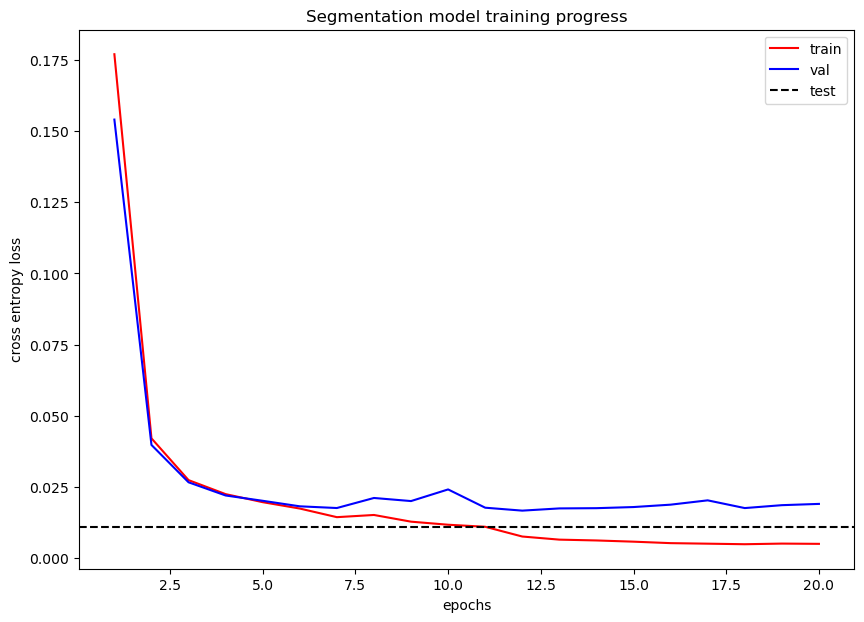

In [7]:
plt.figure(figsize=(10,7))
epochs = list(range(1, 21))
plt.plot(epochs, tr_loss, 'r', label='train')
plt.plot(epochs, va_loss, 'b', label='val')
plt.axhline(test_loss / len(te_dataloader), color='black', linestyle='--', label='test') 
plt.ylabel("cross entropy loss")
plt.xlabel("epochs")
plt.title("Segmentation model training progress")
plt.legend()

## Interpreting model predictions

In [332]:
mode = "test"

transform = T.Compose([
    T.Resize((256, 256)),
    # Don't convert to tensor yet to facilitate visualization steps
])

image_path = f'./findit2/torchdataset/test/1/X51005568866.png'
## image_path = f'./findit2/torchdataset/test/1/X51005757243.png'
# image_path = f'./findit2/torchdataset/test/1/X51006557117.png'
# image_path = f'./findit2/torchdataset/test/1/X51006557195.png'

# Load the original image
original_image = Image.open(image_path).convert('RGB')
original_size = original_image.size  # Width, Height

# Apply the same transformations as during training (excluding ToTensor)
transformed_image = transform(original_image)  # Resized image

In [333]:
model.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():
    input_tensor = T.functional.to_tensor(transformed_image).unsqueeze(0).to(device)  # Add batch dimension and transfer to GPU
    output = model(input_tensor)['out']
    predictions = torch.argmax(output.squeeze(), dim=0).detach().cpu().numpy()  # Convert to numpy array for visualization

In [334]:
predictions_prob = torch.softmax(output, dim=1)[0][1]

In [337]:
# Resize predictions back to the original image size
predictions_resized = resize(predictions_prob, (original_size[1], original_size[0]), 
                             order=0, preserve_range=True, anti_aliasing=False)


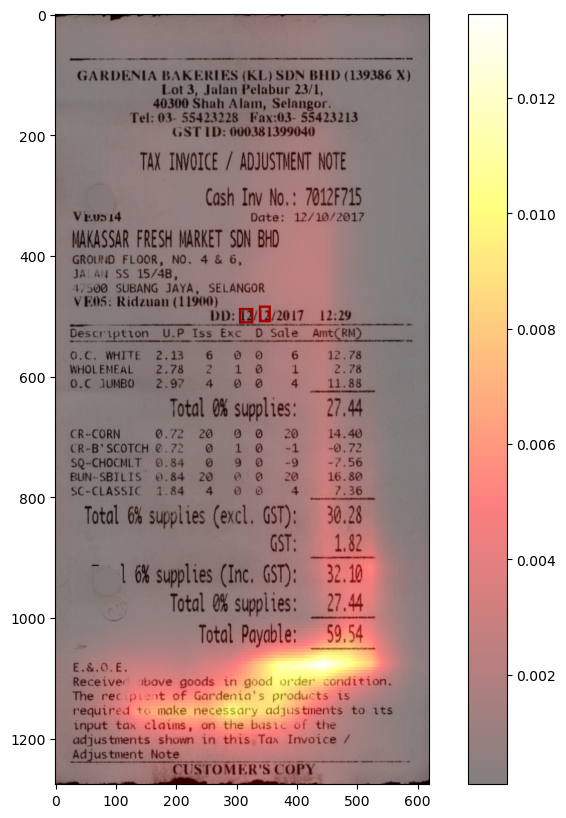

In [338]:
def draw_bounding_boxes(image, annotations):
    draw = ImageDraw.Draw(image)
    for ann in annotations['regions']:
        shape_attr = ann['shape_attributes']
        x, y, w, h = shape_attr['x'], shape_attr['y'], shape_attr['width'], shape_attr['height']
        draw.rectangle([(x, y), (x+w, y+h)], outline="red", width=4)
    return image

annotations = df[mode][df[mode]["image"]==image_path.split("/")[-1]]["forgery annotations"].iloc[0]

# Load the original image without resizing to maintain original dimensions for visualization
original_image = Image.open(image_path).convert('RGB')
drawn_image = draw_bounding_boxes(original_image, annotations)  # Assume 'annotations' is defined

# Convert drawn image to array for overlaying
import numpy as np
drawn_image_array = np.array(drawn_image)

# Create a figure to display the results
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Display original image
ax.imshow(drawn_image_array)
# Overlay heatmap (You may need to adjust the alpha for better visualization)
heatmap = ax.imshow(predictions_resized, cmap='hot', interpolation='nearest', alpha=0.5)
plt.colorbar(heatmap)
plt.show()